<h2 id="Mihaly-Kollo">Mihaly Kollo</h2>
<h4>Principal Laboratory Research Scientist</h4>
<h2 id="Francis-Crick-Insitute"><span style="font-size: 18pt;">Francis Crick Insitute</span></h2>
<h2 id="kollom@crick.ac.uk"><span style="font-size: 18pt; color: #3598db;">kollom@crick.ac.uk</span></h2>
<p>&nbsp;</p>
<h1 id="NEURON-tutorial"><span style="text-decoration: underline;"><span style="font-family: Calibri, sans-serif; font-size: 24pt;">NEURON tutorial</span></span></h1>
<div class="alias" style="box-sizing: border-box; color: #212529; font-family: Montserrat, sans-serif; font-size: 16px; background-color: #ffffff;">
<p id="tinyurl.com/neurontutorial" class="text-break font-weight-bold" style="box-sizing: border-box; font-weight: bold; overflow-wrap: break-word;"></p>
</div>

<p><span style="font-size: 18pt; color: #3598db;">tinyurl.com/neurontutorial</span></p>

<h2>Checking if everyting is installed</h2>

In [124]:
import sys

print("The Python version of this kernel is: " + sys.version)

The Python version of this kernel is: 3.9.6 (default, Aug  5 2022, 15:21:02) 
[Clang 14.0.0 (clang-1400.0.29.102)]


In [125]:
!nrniv --version

NEURON -- VERSION 8.2.1 HEAD (c1590692) 2022-08-09


In [126]:
import neuron

print("The installed neuron version for Python is: " + neuron.__version__)

The installed neuron version for Python is: 8.2.1


In [127]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

<h2>Neuron basics</h2>

<p>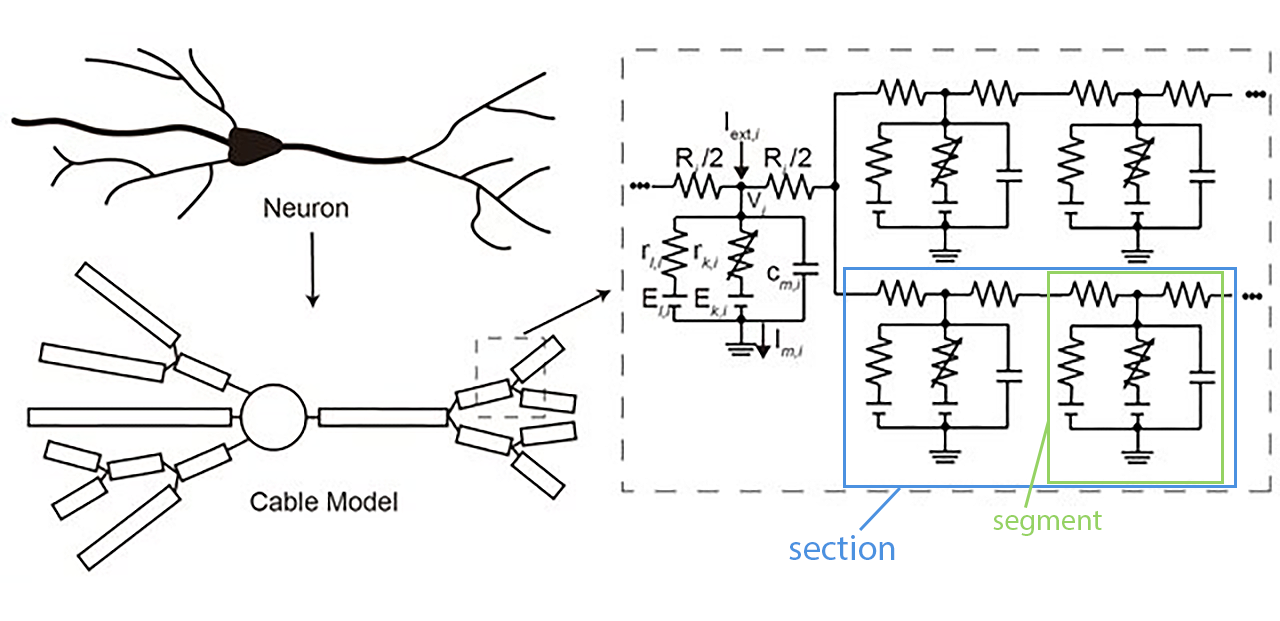</p>

<p><img src="https://neuron.yale.edu/neuron/static/docs/neuronpython/_images/python_hoc_neuron.png" alt="NEURON + Python Basics &mdash; NEURON + Python Tutorials 7.5 documentation" /></p>

<p><a href="https://senselab.med.yale.edu/ModelDB/" target="_blank" rel="noopener">ModelDB</a></p>
<p>&nbsp;</p>
<p><a href="https://nrn.readthedocs.io/en/latest/python/index.html" target="_blank" rel="noopener">https://nrn.readthedocs.io/en/latest/python/index.html</a></p>
<p>&nbsp;</p>
<p><a href="https://www.neuron.yale.edu/phpBB/search.php" target="_blank" rel="noopener">https://www.neuron.yale.edu/phpBB/search.php</a></p>


<h2>☐ Make a ball model and measure Ri, mTau with current injection</h2>

<p>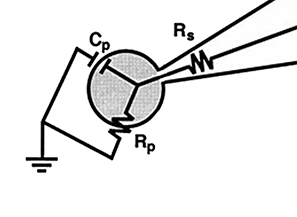</p>

In [128]:
from neuron import h, gui
from neuron.units import mV

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [129]:
def clear_all_sections():    
    for sec in h.allsec():
        h.delete_section(sec=sec)

In [185]:
# Define cell model 

def make_section(diam, length, g_pas, name):
    # "Round" cell  (50x50 µm cylinder)
    section = h.Section(name=name)
    section.L    = length # cylinder length in µm
    section.diam = diam # cylinder diameter in µm

    # Adding a leak channel
    section.insert("pas")
    section.g_pas = g_pas # leak conductance in S/µm - let's make it 100 nS/um²
    return section

def make_soma(diam, g_pas):
    clear_all_sections()
    soma = make_section(diam, diam, g_pas, name="soma")
    return soma


In [186]:
# Check soma parameters
soma = make_soma(diam=40, g_pas=0.0001)
print(soma.psection())
print(h.topology())

{'point_processes': {}, 'density_mechs': {'pas': {'g': [0.0001], 'e': [-70.0], 'i': [0.0]}}, 'ions': {}, 'morphology': {'L': 40.0, 'diam': [40.0], 'pts3d': [], 'parent': None, 'trueparent': None}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'soma', 'hoc_internal_name': '__nrnsec_0x7febd02f3720', 'cell': None}

|-|       soma(0-1)

1.0


In [187]:
def sim_voltage_response(segment, i_stim, v_init=-70, tstop = 400):    

    voltage = h.Vector()
    voltage.record(segment._ref_v)
   
    stim = h.IClamp(segment)
    stim.delay = tstop/4
    stim.dur = tstop/4
    stim.amp = i_stim
    
    current = h.Vector()
    current.record(stim._ref_i)

    t = h.Vector()
    t.record(h._ref_t)
    h.tstop = tstop
    h.v_init = v_init    
    h.run()
    return t, voltage, current

def plot_voltage_response(t, voltage, current, title=""):
    f, (ax_v, ax_c) = plt.subplots(2,1, figsize=(5,3), gridspec_kw = {'height_ratios':[3, 1]})
    ax_v.plot(t,voltage, 'darkblue')    
    ax_c.plot(t,current*1000, 'crimson')

    ax_v.set_ylabel('Voltage (mV)')
    ax_v.spines['right'].set_visible(False)
    ax_v.spines['top'].set_visible(False)
    ax_v.spines['bottom'].set_visible(False)
    ax_v.get_xaxis().set_visible(False)


    ax_c.set_ylabel('Current (nA)')
    ax_c.set_xlabel('Time (ms)')
    ax_c.spines['right'].set_visible(False)
    ax_c.spines['top'].set_visible(False)
    f.suptitle(title)


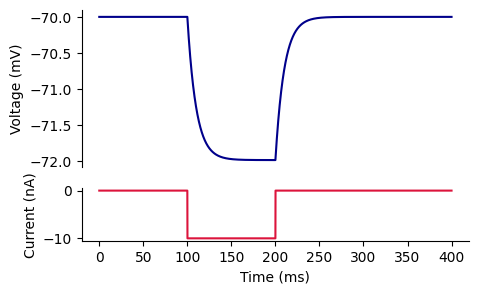

In [188]:
soma = make_soma(diam=40, g_pas=0.0001)

(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current)

In [134]:
def signal_between(signal, t, ms_from, ms_to):
    sample_from = np.where(t.as_numpy()>ms_from)[0][0]
    sample_to = np.where(t.as_numpy()>ms_to)[0][0]
    return signal.as_numpy()[range(sample_from, sample_to)]

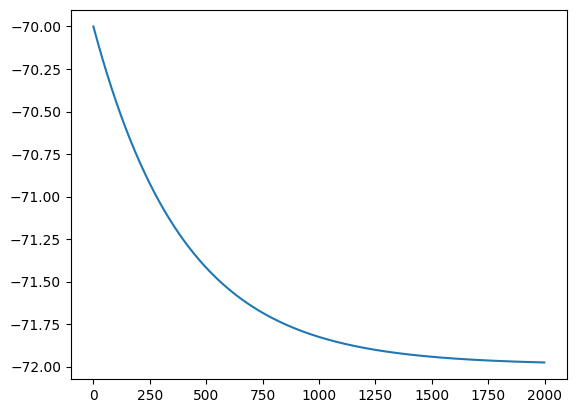

In [190]:
plt.plot(signal_between(voltage, t, 100, 150))

10.012494798170119

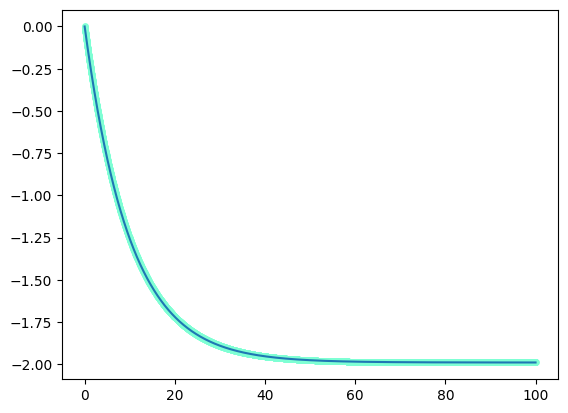

In [191]:
def exp_decay(t, a, tau):
    return a - a * np.exp(-t/tau)

V_decay = signal_between(voltage, t, 100, 200)
V_decay -= V_decay[0]
t_decay = signal_between(t, t, 100, 200)
t_decay-=t_decay[0]
(a, tau), _ = curve_fit(exp_decay, t_decay, V_decay, (10, 10))

plt.plot(t_decay, V_decay)
plt.scatter(t_decay, exp_decay(t_decay, a, tau), s=15, c='aquamarine')
tau

In [135]:
def passive_properties(t, voltage, current):
    V_decay = signal_between(voltage, t, 100, 200)
    V_decay -= V_decay[0]
    t_decay = signal_between(t, t, 100, 200)
    t_decay-=t_decay[0]
    
    (V_response, tau_m), _ = curve_fit(exp_decay, t_decay, V_decay, (10, 10))
    I_stim = np.mean(signal_between(current, t, 100, 200)) - np.mean(signal_between(current, t, 0, 100))
    
    # R = U/I   ---  millivolt 10^-3 / nanoamp 10^-9 =>  10^6 (megaohm)
    R_m = V_response / I_stim
    # C_m = tau_m / R_m   ---  millisecond 10^-3 / megaohm 10^6 =>  10^-9 (nanofarad)    
    C_m = tau_m / R_m * 1000 # convert to picofarad
    return R_m, tau_m, C_m

R_m = 198.99 MΩ  ---  𝜏_m = 10.01 ms --- C_m = 50.32 pF


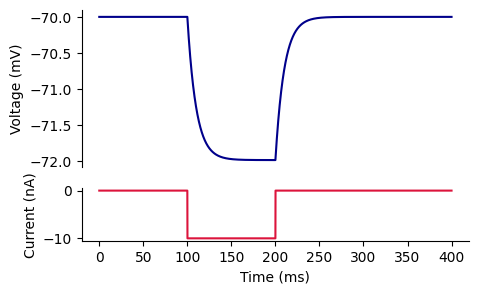

In [136]:
soma = make_soma(diam=40, g_pas=0.0001)
(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current)

(R_m, tau_m, C_m) = passive_properties(t, voltage, current)
print("R_m = %0.2f MΩ  ---  𝜏_m = %0.2f ms --- C_m = %0.2f pF" % (R_m, tau_m, C_m))

In [137]:
# # Sanity check
# convert area to cm^2
soma_area = soma(0.5).area() / 1e12 * 1e4 
# specific membrane capacitance is in μF/cm2 - most often 1 μF/cm2
# calculate total capacitance in pF (convert from uF)
print("calculated C_m = %0.2f" % (soma_area * soma(0.5).cm * 1000000))

# conductances are given in S/cm^2
total_conductance = soma_area * soma(0.5).g_pas
# convert from Ω to MΩ
print("calculated R_m = %0.2f" % ((1/total_conductance) / 1000000))

calculated C_m = 50.27
calculated R_m = 198.94


<h2>Change diameter, Rm, Ra, Cm and see how it affects Ri and mTau</h2>

R_m = 198.99 MΩ  ---  𝜏_m = 10.01 ms --- C_m = 50.32 pF


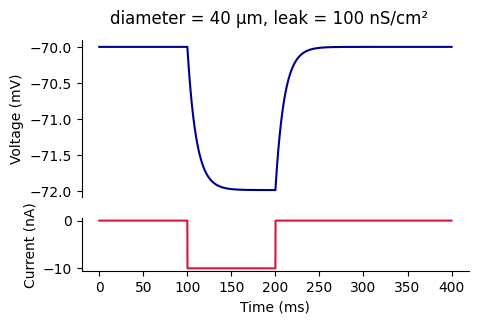

In [138]:
soma = make_soma(diam=40, g_pas=0.0001)
(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current, "diameter = 40 µm, leak = 100 nS/cm²")

(R_m, tau_m, C_m) = passive_properties(t, voltage, current)
print("R_m = %0.2f MΩ  ---  𝜏_m = %0.2f ms --- C_m = %0.2f pF" % (R_m, tau_m, C_m))

R_m = 3183.89 MΩ  ---  𝜏_m = 10.01 ms --- C_m = 3.14 pF


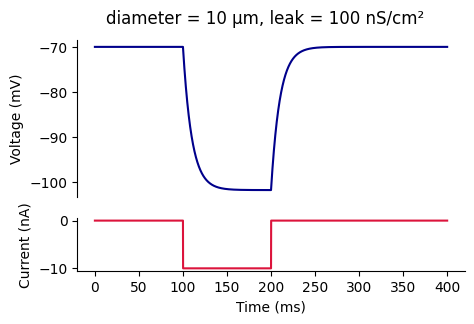

In [139]:
soma = make_soma(diam=10, g_pas=0.0001)
(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current, "diameter = 10 µm, leak = 100 nS/cm²")

(R_m, tau_m, C_m) = passive_properties(t, voltage, current)
print("R_m = %0.2f MΩ  ---  𝜏_m = %0.2f ms --- C_m = %0.2f pF" % (R_m, tau_m, C_m))

R_m = 397.99 MΩ  ---  𝜏_m = 20.01 ms --- C_m = 50.28 pF


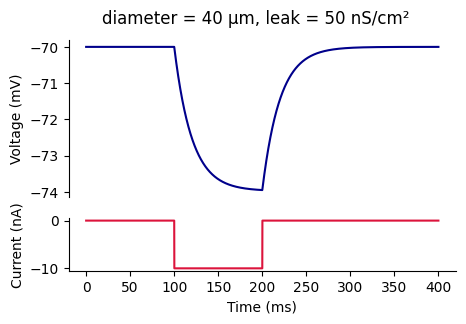

In [140]:
soma = make_soma(diam=40, g_pas=0.00005)
(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current, "diameter = 40 µm, leak = 50 nS/cm²")

(R_m, tau_m, C_m) = passive_properties(t, voltage, current)
print("R_m = %0.2f MΩ  ---  𝜏_m = %0.2f ms --- C_m = %0.2f pF" % (R_m, tau_m, C_m))

<h2>Add dendrites and axons of increasing total areas. What happens to Ri and mTau? Pay special attention to whether mTau is a single exponential.</h2>

R_m = 198.99 MΩ  ---  𝜏_m = 10.01 ms --- C_m = 50.32 pF


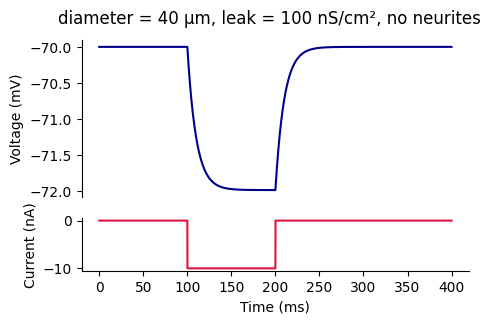

In [141]:
soma = make_soma(diam=40, g_pas=0.0001)
(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current, "diameter = 40 µm, leak = 100 nS/cm², no neurites")

(R_m, tau_m, C_m) = passive_properties(t, voltage, current)
print("R_m = %0.2f MΩ  ---  𝜏_m = %0.2f ms --- C_m = %0.2f pF" % (R_m, tau_m, C_m))

In [142]:
soma = make_soma(diam=40, g_pas=0.0001)
dendrites = [make_section(4, 1000, 0.0001, "dend[%d]"%i) for i in range(5)]
axon = make_section(1, 1000, 0.0001, "axon")

for sec in dendrites:
    sec.connect(soma(1), 0)

axon.connect(soma(0), 1)

h.topology()


|-|       soma(0-1)
   `|       dend[0](0-1)
   `|       dend[1](0-1)
   `|       dend[2](0-1)
   `|       dend[3](0-1)
   `|       dend[4](0-1)
 `|       axon(1-0)



1.0

In [143]:
s = h.Shape()

R_m = 16.51 MΩ  ---  𝜏_m = 8.31 ms --- C_m = 503.50 pF


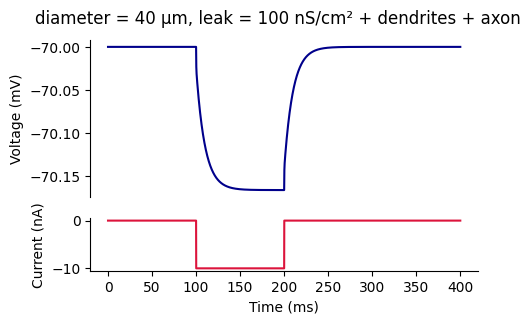

In [144]:
(t, voltage, current) = sim_voltage_response(soma(0.5), -0.01)
plot_voltage_response(t, voltage, current, "diameter = 40 µm, leak = 100 nS/cm² + dendrites + axon")

(R_m, tau_m, C_m) = passive_properties(t, voltage, current)
print("R_m = %0.2f MΩ  ---  𝜏_m = %0.2f ms --- C_m = %0.2f pF" % (R_m, tau_m, C_m))

8.313889337096493

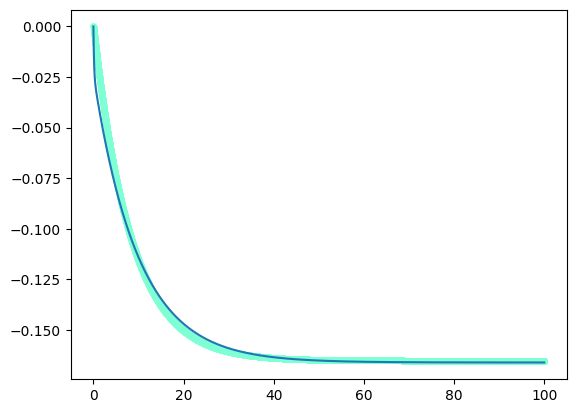

In [145]:

V_decay = signal_between(voltage, t, 100, 200)
V_decay -= V_decay[0]
t_decay = signal_between(t, t, 100, 200)
t_decay-=t_decay[0]
(a, tau), _ = curve_fit(exp_decay, t_decay, V_decay, (10, 10))

plt.plot(t_decay, V_decay)
plt.scatter(t_decay, exp_decay(t_decay, a, tau), s=15, c='aquamarine')
tau

<h2>Add HH Na and K voltage-gate channel to the ball model and inject current steps (add one at the time to see the effect of each one, and then combine)</h2>

In [146]:
def make_hh_section(diam, length, name):
    # "Round" cell  (50x50 µm cylinder)
    section = h.Section(name=name)
    section.L    = length # cylinder length in µm
    section.diam = diam # cylinder diameter in µm
    # Adding a leak channel
    section.insert("hh")
    for seg in section:
        seg.hh.gnabar = 0.12 # Na conductance in S/cm2     
        seg.hh.gkbar = 0.036 # K conductance in S/cm2             
        seg.hh.gl = 0.0001  # Leak conductance in S/cm2
        seg.hh.el = -54.3 * mV  # Reversal potential     
    return section

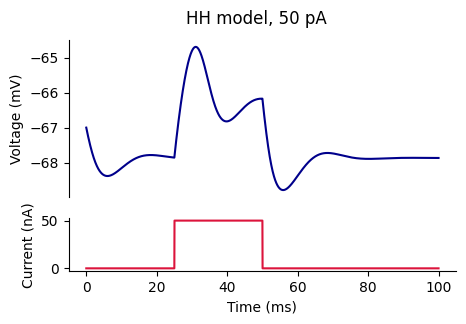

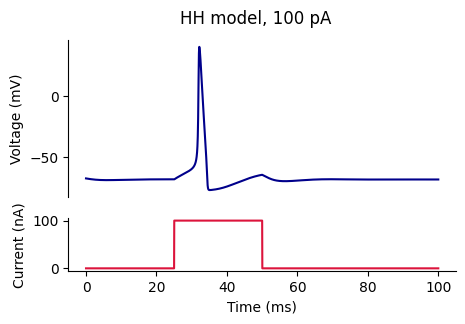

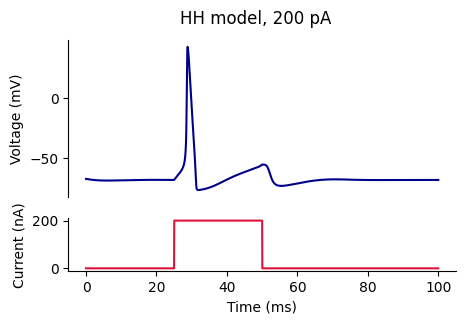

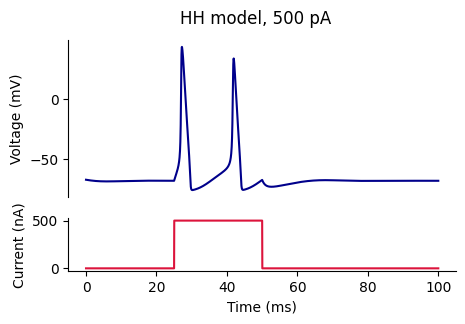

In [147]:
soma = make_hh_section(diam=40, length=40, name="soma")

amplitudes = [50, 100, 200, 500]

traces = {}

for ampl in amplitudes:
    (t, voltage, current) = sim_voltage_response(soma(0.5), ampl/1000, v_init=-67, tstop=100)
    plot_voltage_response(t, voltage, current, "HH model, %d pA" % ampl)
    traces[ampl]=voltage.as_numpy().copy()


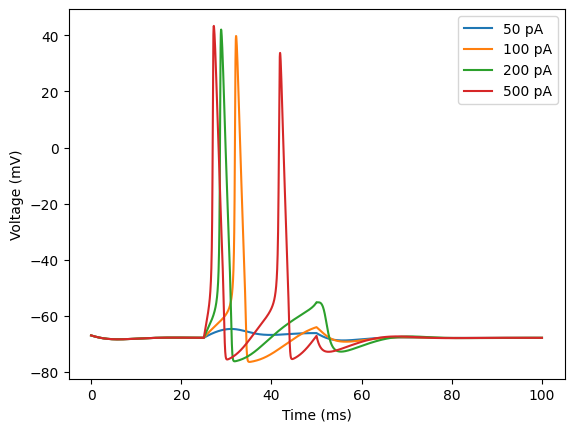

In [148]:
for ampl in amplitudes:
    plt.plot(t, traces[ampl], label = "%d pA" % ampl)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.show()


<h2>Measure gNa and gKv as a function of current injection at the soma, and plot activation curves (from resting Vm)</h2>

In [149]:
def sim_na_k_conductances(segment, i_stim, v_init=-70, tstop = 400):    

    voltage = h.Vector()
    voltage.record(segment._ref_v)
    
    g_na = h.Vector()
    g_na.record(segment.hh._ref_gna)
    
    g_k = h.Vector()
    g_k.record(segment.hh._ref_gk)
    
    stim = h.IClamp(segment)
    stim.delay = tstop/4
    stim.dur = tstop/4
    stim.amp = i_stim
    
    current = h.Vector()
    current.record(stim._ref_i)

    t = h.Vector()
    t.record(h._ref_t)
    h.tstop = tstop
    h.v_init = v_init    
    h.run()
    return t, voltage, current, g_na, g_k


def plot_na_k_conductances(t, voltage, current, gna, gk, title=""):
    f, (ax_v, ax_c, ax_na, ax_k) = plt.subplots(4,1, figsize=(5,7), gridspec_kw = {'height_ratios':[3, 1, 2, 2]})
    ax_v.plot(t,voltage, 'darkblue')    
    ax_c.plot(t,current*1000, 'crimson')
    ax_na.plot(t, gna, 'coral')
    ax_k.plot(t, gk, 'darkcyan')

    ax_v.set_ylabel('Voltage (mV)')
    ax_v.spines['right'].set_visible(False)
    ax_v.spines['top'].set_visible(False)
    ax_v.spines['bottom'].set_visible(False)
    ax_v.get_xaxis().set_visible(False)

    ax_c.set_ylabel('Current (nA)')
    ax_c.spines['right'].set_visible(False)
    ax_c.spines['top'].set_visible(False)
    ax_c.spines['bottom'].set_visible(False)
    ax_c.get_xaxis().set_visible(False)

    ax_na.set_ylabel('$g_{Na}$ (S/cm²)')
    ax_na.spines['right'].set_visible(False)
    ax_na.spines['top'].set_visible(False)
    ax_na.spines['bottom'].set_visible(False)
    ax_na.get_xaxis().set_visible(False)

    
    ax_k.set_ylabel('$g_{K}$ (S/cm²)')
    ax_k.spines['right'].set_visible(False)
    ax_k.spines['top'].set_visible(False)
    ax_k.set_xlabel('Time (ms)')

    f.suptitle(title)


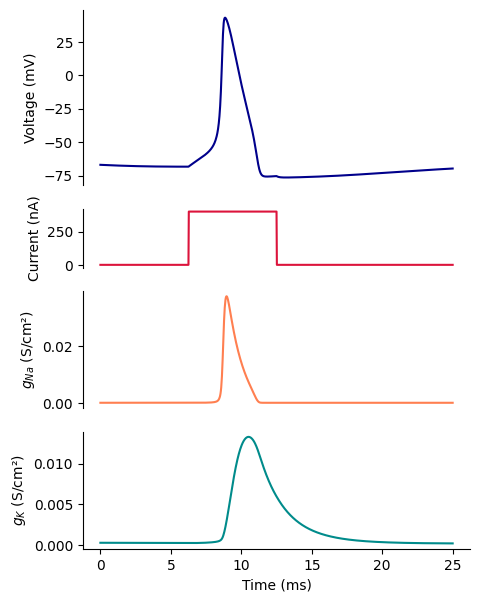

In [150]:
(t, voltage, current, g_na, g_k) = sim_na_k_conductances(soma(0.5), 0.4, v_init=-67, tstop=25)
plot_na_k_conductances(t, voltage, current, g_na, g_k)
traces[ampl]=voltage.as_numpy().copy()

In [151]:
amplitudes = np.linspace(0, 0.5, 200)
g_na_list = []
g_k_list = []
current_list = []
for amplitude in amplitudes:
    (t, voltage, current, g_na, g_k) = sim_na_k_conductances(soma(0.5), amplitude, v_init=-67, tstop=25)
    current_list.append(np.mean(current.as_numpy())*1000)
    g_na_list.append(np.mean(g_na.as_numpy())*1000)
    g_k_list.append(np.mean(g_k.as_numpy())*1000)

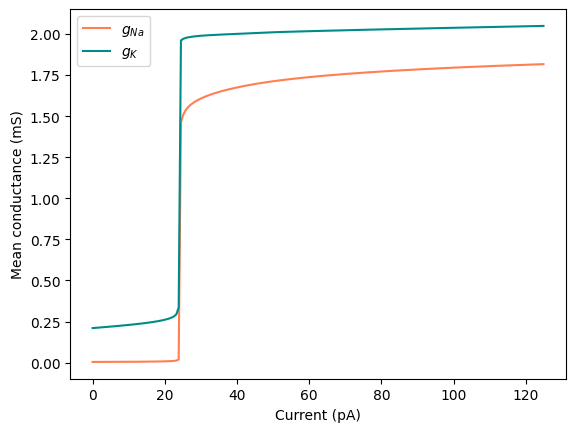

In [152]:
plt.plot(current_list, g_na_list, 'coral', label="$g_{Na}$")
plt.plot(current_list, g_k_list, 'darkcyan', label="$g_{K}$")

plt.xlabel("Current (pA)")
plt.ylabel("Mean conductance (mS)")
plt.legend()
plt.show()


<h2>Measure gNa and gKv to a large current step from increasing resting Vms, and plot inactivation curves.</h2>

In [153]:
v_inits = np.linspace(-100, 20, 200)
g_na_list = []
g_k_list = []
v_init_list = []
for v_init in v_inits:
    (t, voltage, current, g_na, g_k) = sim_na_k_conductances(soma(0.5), 0.4, v_init=v_init, tstop=25)
    v_init_list.append(v_init)
    g_na_list.append(np.mean(g_na.as_numpy())*1000)
    g_k_list.append(np.mean(g_k.as_numpy())*1000)

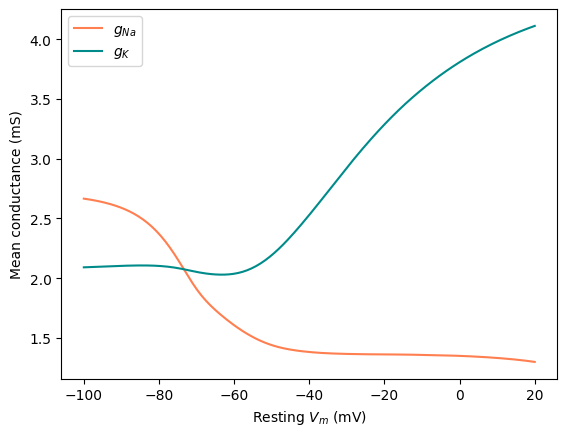

In [154]:
plt.plot(v_init_list, g_na_list, 'coral', label="$g_{Na}$")
plt.plot(v_init_list, g_k_list, 'darkcyan', label="$g_{K}$")

plt.xlabel("Resting $V_{m}$ (mV)")
plt.ylabel("Mean conductance (mS)")
plt.legend()
plt.show()

<h2>Give two large current steps separated by an increasing time interval, and plot gNa. What happens?</h2>

In [155]:
def sim_na_k_conductances_pairedstim(segment, i_stim, t_interval, pulse_width = 1, v_init=-70, tstop = 50):    

    voltage = h.Vector()
    voltage.record(segment._ref_v)
    
    g_na = h.Vector()
    g_na.record(segment.hh._ref_gna)
    
    g_k = h.Vector()
    g_k.record(segment.hh._ref_gk)

    total_samples = tstop * int(h.steps_per_ms)
    pulse_samples = int(pulse_width * h.steps_per_ms)
    interval_samples = int(t_interval * h.steps_per_ms)
    t_stim = h.Vector(np.linspace(0, tstop, int(h.steps_per_ms*tstop)))
    i_waveform = np.zeros(total_samples)
    i_waveform[pulse_samples:pulse_samples*2] = np.ones(pulse_samples)*i_stim
    i_waveform[pulse_samples*2+interval_samples:pulse_samples*3+interval_samples] = np.ones(pulse_samples)*i_stim

    i_stim = h.Vector(i_waveform)
    ic = h.IClamp(soma(0.5))
    ic.delay = 0
    ic.dur = tstop    
    i_stim.play(ic._ref_amp, t_stim, True)  
    
    current = h.Vector()
    current.record(ic._ref_i)

    t = h.Vector()
    t.record(h._ref_t)
    h.tstop = tstop
    h.v_init = v_init    
    h.run()
    return t, voltage, current, g_na, g_k


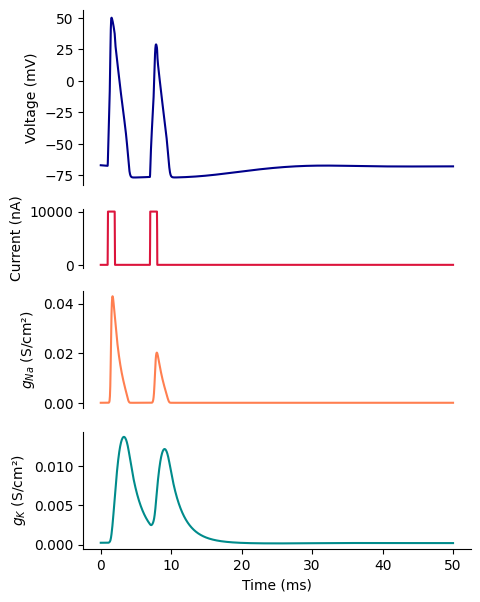

In [156]:
(t, voltage, current, g_na, g_k) = sim_na_k_conductances_pairedstim(soma(0.5), 10, t_interval = 5, v_init=-67)
plot_na_k_conductances(t, voltage, current, g_na, g_k)
traces[ampl]=voltage.as_numpy().copy()

In [157]:
intervals = np.linspace(1, 10, 100)
g_na_list = []
g_k_list = []
interval_list = []
for interval in intervals:
    (t, voltage, current, g_na, g_k) = sim_na_k_conductances_pairedstim(soma(0.5), 10, interval, v_init=-67)
    interval_list.append(interval)
    g_na_list.append(np.mean(g_na.as_numpy())*1000)
    g_k_list.append(np.mean(g_k.as_numpy())*1000)

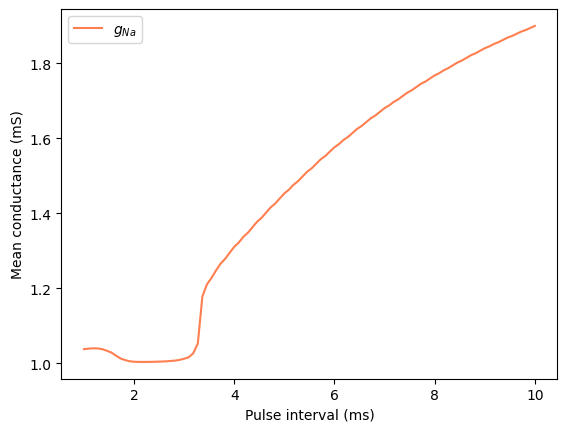

In [158]:
plt.plot(interval_list, g_na_list, 'coral', label="$g_{Na}$")
plt.xlabel("Pulse interval (ms)")
plt.ylabel("Mean conductance (mS)")
plt.legend()
plt.show()

<h2>Synaptic integration</h2>

<h2>Add a single alpha excitatory synapse in the soma and then in the dendrite, progressively further away, and record at the soma. What changes?</h2>


|-|       soma(0-1)
   `---------|       dend[0](0-1)
   `---------|       dend[1](0-1)
   `---------|       dend[2](0-1)
   `---------|       dend[3](0-1)
   `---------|       dend[4](0-1)
 `---------|       axon(1-0)



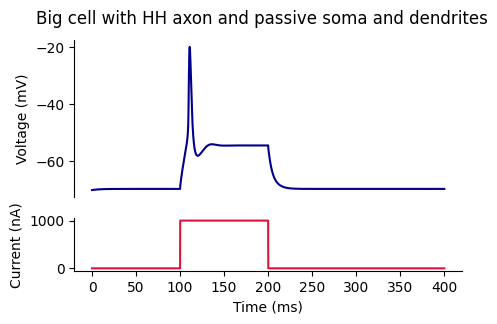

In [159]:
soma = make_soma(diam=40, g_pas=0.0001)
dendrites = [make_section(4, 500, 0.0001, "dend[%d]"%i) for i in range(5)]
axon = make_hh_section(3, 200, "axon")

for sec in dendrites:
    sec.nseg = 10
    sec.connect(soma(1), 0)

axon.connect(soma(0), 1)
axon.nseg = 10

h.topology()

(t, voltage, current) = sim_voltage_response(soma(0.5), 1)
plot_voltage_response(t, voltage, current, "Big cell with HH axon and passive soma and dendrites")


In [160]:
def sim_voltage(segment, i_stim, v_init=-69.25, tstop = 1000):    
    voltage = h.Vector()
    voltage.record(segment._ref_v)    
    t = h.Vector()
    t.record(h._ref_t)
    h.tstop = tstop
    h.v_init = v_init    
    h.run()
    return t, voltage

def plot_voltage(t, voltage, title=""):
    f, ax_v = plt.subplots(1,1, figsize=(5,3))
    ax_v.plot(t, voltage, 'darkblue')    
    ax_v.set_ylabel('Voltage (mV)')
    ax_v.spines['right'].set_visible(False)
    ax_v.spines['top'].set_visible(False)    
    ax_v.set_xlabel('Time (ms)')
    f.suptitle(title)

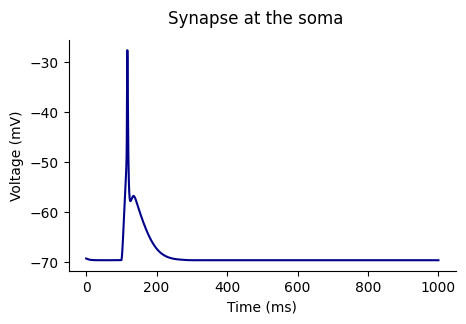

In [161]:
syn = h.AlphaSynapse(soma(0.5))
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse at the soma")

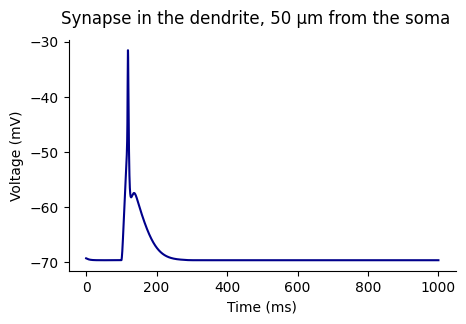

In [162]:
syn_distance = 50 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

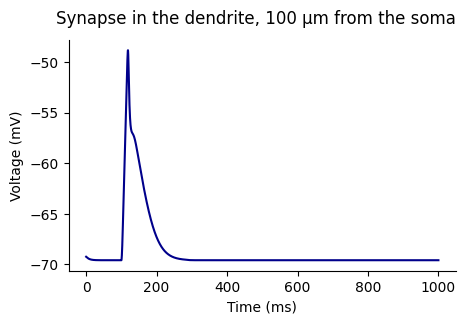

In [163]:
syn_distance = 100 # µm

syn = h.AlphaSynapse(dendrites[0](syn_distance / dendrites[0].L))
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

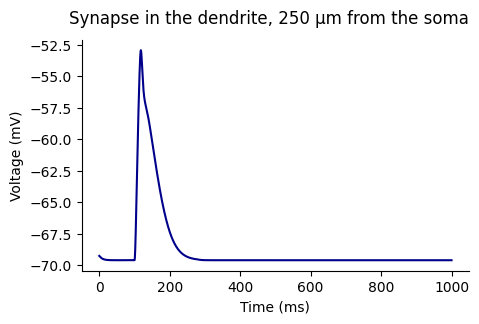

In [164]:
syn_distance = 250 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

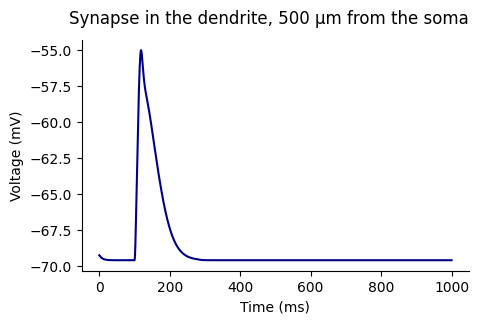

In [165]:
syn_distance = 500 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

<h2>Do the same but record at the dendrite where the synapse is. How does it compare to the soma? What changes with distance?</h2>

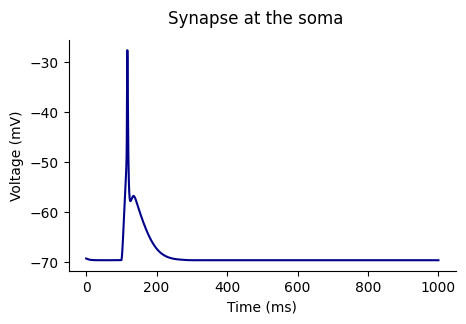

In [166]:
syn = h.AlphaSynapse(soma(0.5))
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse at the soma")

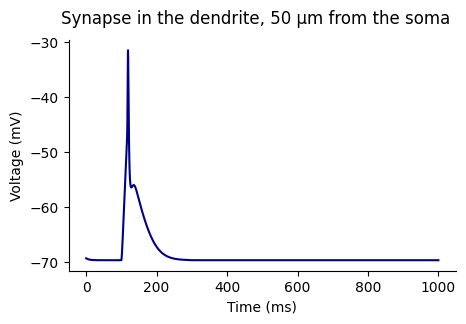

In [167]:
syn_distance = 50 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(d_segment, 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

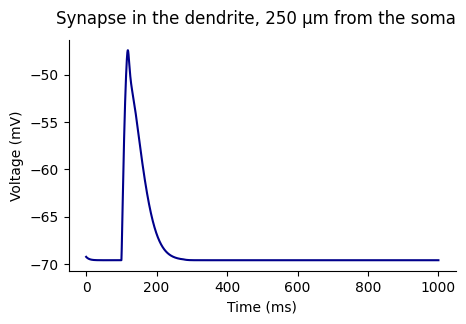

In [168]:
syn_distance = 250 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(d_segment, 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

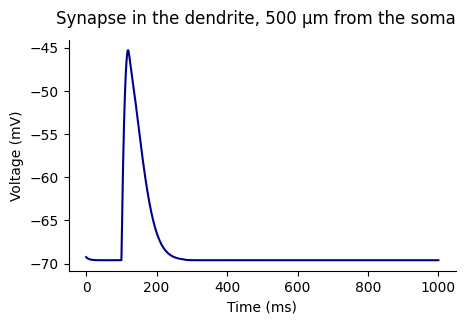

In [169]:
syn_distance = 500 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(d_segment, 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

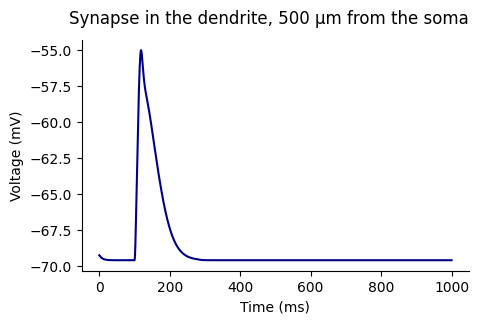

In [170]:
(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

<h2>Change Rm, Cm and Ra - how does it affect the EPSP locally and at the soma?</h2>

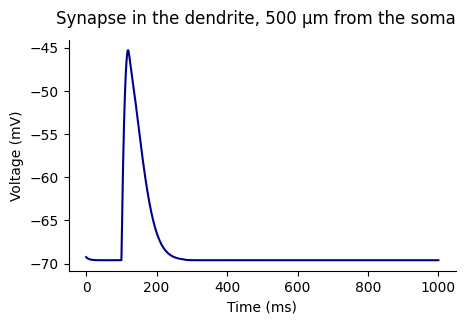

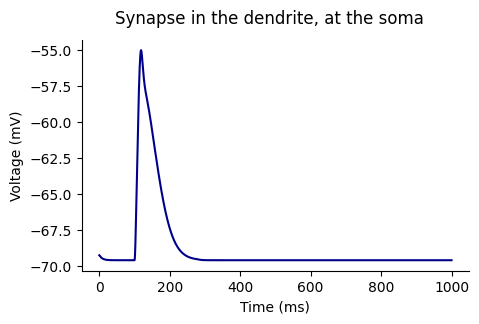

In [171]:
soma = make_soma(diam=40, g_pas=0.0001)
dendrites = [make_section(4, 500, 0.0001, "dend[%d]"%i) for i in range(5)]
axon = make_hh_section(3, 200, "axon")

for sec in dendrites:
    sec.nseg = 10
    sec.connect(soma(1), 0)

axon.connect(soma(0), 1)
axon.nseg = 10

syn_distance = 500 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(d_segment, 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, at the soma")


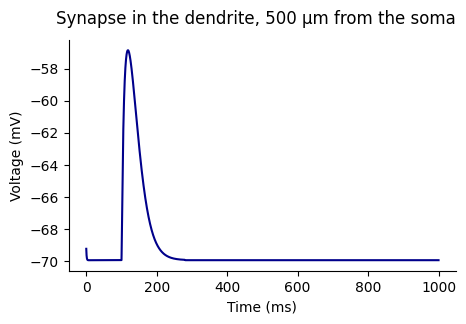

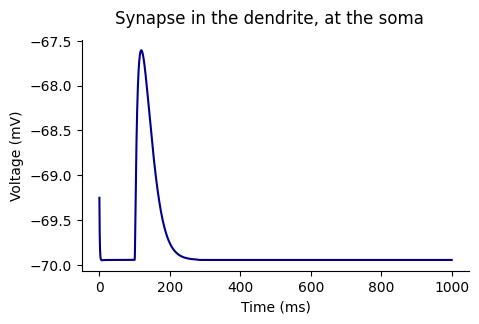

In [172]:
soma = make_soma(diam=40, g_pas=0.001)
dendrites = [make_section(4, 500, 0.001, "dend[%d]"%i) for i in range(5)]
axon = make_hh_section(3, 200, "axon")

for sec in dendrites:
    sec.nseg = 10
    sec.connect(soma(1), 0)

axon.connect(soma(0), 1)
axon.nseg = 10

syn_distance = 500 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)
syn = h.AlphaSynapse(d_segment)
syn.onset =  100 # ms
syn.tau = 18 # ms
syn.gmax = 0.025 # µS
syn.e = -15 # mV

(t, voltage) = sim_voltage(d_segment, 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, at the soma")


<h2>In a model with dendrites, compare the somatic EPSPs generated by 10 synapses in the same dendritic location versus 10 synapses in different dendritic branches.</h2>

<h2>Repeat in the presence of NMDA receptors. What changes?</h2>

In [173]:
#!nrnivmodl -coreneuron .
#!nrnivmodl .
# h.nrn_load_dll('x86_64/.libs/libnrnmech.so')


In [174]:
clear_all_sections()

soma = make_soma(diam=40, g_pas=0.0001)
dendrites = [make_section(4, 500, 0.0001, "dend[%d]"%i) for i in range(5)]
axon = make_hh_section(3, 200, "axon")

for sec in dendrites:
    sec.nseg = 10
    sec.connect(soma(1), 0)

axon.connect(soma(0), 1)
axon.nseg = 10

syn_distance = 500 # µm

d_segment = dendrites[0](syn_distance / dendrites[0].L)

In [183]:

pre = make_section(10, 10, 0.0001, "pre") 
pre.insert("hh")
pre(0.5).hh.gnabar = 0.1
pre(0.5).hh.gkbar = 0.03
pre(0.5).hh.gl = 0.0001  # Leak conductance in S/cm2
pre(0.5).hh.el = -90 * mV  # Reversal potential     

stim = h.IClamp(pre(0.5))
stim.delay = 10
stim.dur = 2    
stim.amp = 1

syn = h.NMDA()
post = syn.loc(0.5)
syn._ref_pre = pre(0.5)._ref_v

h.Cmax_NMDA   = 1 #  (mM) max transmitter concentration
h.Cdur_NMDA   = 1 #  (ms) transmitter duration (rising phase)
h.Alpha_NMDA  = 0.072 #  (/ms mM) forward (binding) rate
h.Beta_NMDA   = 0.0066 # (/ms) backward (unbinding) rate
h.Erev_NMDA   = 0 # (mV) reversal potential
h.Prethresh_NMDA  = 0 # (mV) voltage level nec for release
h.Deadtime_NMDA   = 1 #  (ms)     mimimum time between release events
h.mg_NMDA     = 2 #  (mM) physiological extracell magnesium
syn.gmax      = 0.02 # (umho) maximum conductance



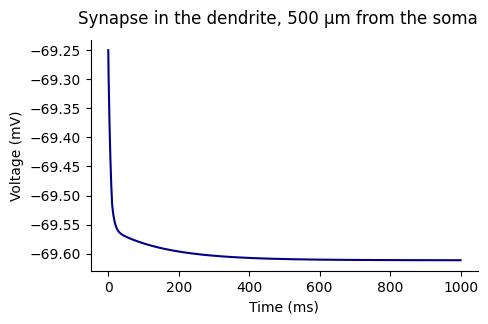

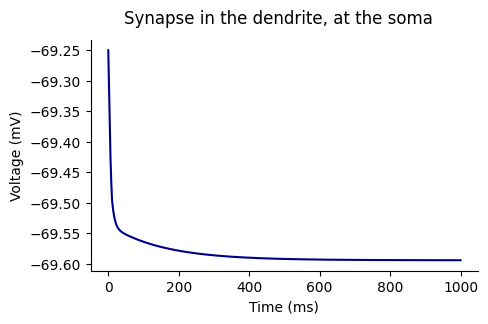

In [184]:

(t, voltage) = sim_voltage(d_segment, 0)
plot_voltage(t, voltage, "Synapse in the dendrite, %d µm from the soma" % syn_distance)

(t, voltage) = sim_voltage(soma(0.5), 0)
plot_voltage(t, voltage, "Synapse in the dendrite, at the soma")